In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder




!pip install transformers torch pandas scikit-learn

In [2]:
df = pd.read_json("train.json")

In [3]:
df["description"][4]

'Spacious 1 Bedroom 1 Bathroom in Williamsburg!Apartment Features:- Renovated Eat in Kitchen With Dishwasher- Renovated Bathroom- Beautiful Hardwood Floors- Lots of Sunlight- Great Closet Space- Freshly Painted- Heat and Hot Water Included- Live in Super Nearby L, J, M & G Trains !<br /><br />Contact Information:Kenneth BeakExclusive AgentC: 064-692-8838Email: kagglemanager@renthop.com, Text or Email to schedule a private viewing!<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><p><a  website_redacted '

We can see here that there are html tags in the text which is not required

In [4]:
#Removal of outlier
upper_bound = np.percentile(df["price"].values, 99.9)
df_filtered = df[df["price"] <= upper_bound]

In [5]:
df_filtered["date"] = pd.to_datetime(df_filtered["created"]).dt.date
df_filtered["year"] = pd.to_datetime(df_filtered["date"]).dt.year
df_filtered["month"] = pd.to_datetime(df_filtered["date"]).dt.month
df_filtered["day"] = pd.to_datetime(df_filtered["date"]).dt.day
df_filtered["hour"] = pd.to_datetime(df_filtered["date"]).dt.hour
df_filtered["weekday"] = pd.to_datetime(df_filtered["date"]).dt.weekday
df_filtered["quarter"] = pd.to_datetime(df_filtered["date"]).dt.quarter
df_filtered.head(5)

<ipython-input-5-200f75a3fb14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["date"] = pd.to_datetime(df_filtered["created"]).dt.date
<ipython-input-5-200f75a3fb14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["year"] = pd.to_datetime(df_filtered["date"]).dt.year
<ipython-input-5-200f75a3fb14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,price,street_address,interest_level,date,year,month,day,hour,weekday,quarter
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,2400,145 Borinquen Place,medium,2016-06-16,2016,6,16,0,3,2
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,3800,230 East 44th,low,2016-06-01,2016,6,1,0,2,2
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,3495,405 East 56th Street,medium,2016-06-14,2016,6,14,0,1,2
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,3000,792 Metropolitan Avenue,medium,2016-06-24,2016,6,24,0,4,2
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,2795,340 East 34th Street,low,2016-06-28,2016,6,28,0,1,2


PREPROCESSING
- Removal of html tags
- Remove numbers and special characters from text
- Convert text to lowercase


In [6]:
def remove_html_tags(description):
    description = re.sub(r'<[^>]+>', '', description)
    description = re.sub(r'\s+', ' ', description)
    return description.strip()


df_filtered['processed_description'] = df_filtered['description'].apply(remove_html_tags)

df_filtered["processed_description"] = df_filtered["description"].apply(lambda desc: desc.lower())

<ipython-input-6-22d1eb9322d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_description'] = df_filtered['description'].apply(remove_html_tags)
<ipython-input-6-22d1eb9322d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["processed_description"] = df_filtered["description"].apply(lambda desc: desc.lower())


In [7]:
def remove_numbers_special_chars(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

df_filtered['processed_description'] = df_filtered['processed_description'].apply(remove_numbers_special_chars)
df_filtered["processed_description_distilBERT"] = df_filtered["processed_description"]

<ipython-input-7-7ac46559ef35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_description'] = df_filtered['processed_description'].apply(remove_numbers_special_chars)
<ipython-input-7-7ac46559ef35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["processed_description_distilBERT"] = df_filtered["processed_description"]


Tokenization : Split the text into words (tokens) for easier processing.

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# Load spaCy's pre-trained model (small model for efficiency)
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def spaCy_tokenize(description):
    doc = nlp(description)
    return doc # Return the spaCy Doc object instead of just token texts

def remove_stopwords_and_lemmatize(doc): # Accept spaCy Doc object
    processed_words = []
    for token in doc:
        if token.text not in stop_words and not token.is_punct: # Access token.text for stop word check
            processed_words.append(token.lemma_)
    return " ".join(processed_words)
# To be removed after testing.
# df_filtered = df_filtered.iloc[:100]
df_filtered['processed_description'] = df_filtered['processed_description'].apply(spaCy_tokenize) # Store Doc objects
df_filtered['processed_description'] = df_filtered['processed_description'].apply(remove_stopwords_and_lemmatize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-9-028db781f529>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_description'] = df_filtered['processed_description'].apply(spaCy_tokenize) # Store Doc objects
<ipython-input-9-028db781f529>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_description'] = df_filtered['processed_description'].apply(remove_stopwords_and_lemmatize)

In [10]:
print(df_filtered['processed_description'].head())

4     spacious   bedroom   bathroom williamsburgapar...
6     brand new gut renovate true   bedroomfind home...
9     flex   bedroom full pressurized walllooking pe...
10    brand new   bedroom   bath apartmentenjoy foll...
15    oversized studio w abundant closet available i...
Name: processed_description, dtype: object


RNN MODEL

In [11]:
tokenizer_rnn = Tokenizer(num_words=10000)
tokenizer_rnn.fit_on_texts(df_filtered['processed_description'])

sequences_rnn = tokenizer_rnn.texts_to_sequences(df_filtered['processed_description'])
max_sequence_length_run = 100

X = pad_sequences(sequences_rnn, maxlen=max_sequence_length_run, padding='post')


In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_filtered['interest_level'])  # Encoded 'low', 'medium', 'high' as integers

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Converting y_train and y_test to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)


In [15]:
model_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length_run),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Softmax for multi-class classification
])

model_rnn.build(input_shape=(None, max_sequence_length_run))  # None for batch size
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_rnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,411,971 (5.39 MB)

 Trainable params: 1,411,971 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Training RNN
history = model_rnn.fit(
    X_train, y_train_one_hot,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6914 - loss: 0.8098 - val_accuracy: 0.6978 - val_loss: 0.7871
Epoch 2/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6959 - loss: 0.7834 - val_accuracy: 0.6985 - val_loss: 0.7400
Epoch 3/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7045 - loss: 0.7127 - val_accuracy: 0.7030 - val_loss: 0.7057
Epoch 4/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7245 - loss: 0.6535 - val_accuracy: 0.6993 - val_loss: 0.7285
Epoch 5/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7455 - loss: 0.6067 - val_accuracy: 0.6912 - val_loss: 0.7240
Epoch 6/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7636 - loss: 0.5643 - val_accuracy: 0.6857 - val_loss: 0.7613
Epoch 7/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7778 - loss: 0.5347 - val_accuracy: 0.6817 - val_loss: 0.7626
Epoch 8/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7893 - loss: 0.5061 - val_

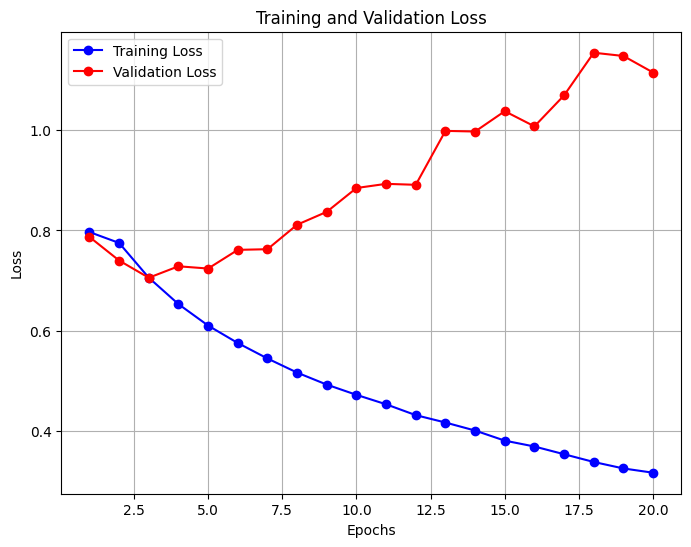

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Here validation loss is significantly higher than the training loss towards the later epochs, so thats why it indicates overfitting.

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

        high       0.29      0.17      0.22       768
         low       0.78      0.81      0.79      6850
      medium       0.36      0.38      0.37      2246

    accuracy                           0.66      9864
   macro avg       0.48      0.45      0.46      9864
weighted avg       0.65      0.66      0.65      9864



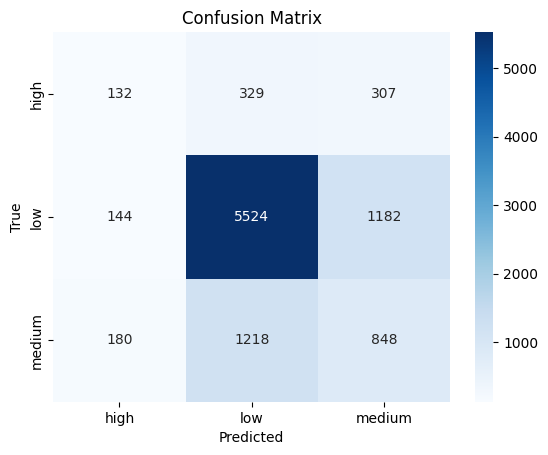

Accuracy: 0.6594


In [17]:
y_pred = model_rnn.predict(X_test).argmax(axis=1)

# Classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


As we can see above the training accuracy goes on increasing along with validation increase,thus suggesting us that there is an imbalance in a dataset.The model is focused on correctly predicting the majority class (low) at the expense of the minority classes (medium and high).So let us class weights to adjust the loss function to penalize the majority class more lightly and the minority classes more heavily. This can help balance the influence of each class during training.

**Using DistilBERT for Sentiment Analysis**

In [ ]:
from sklearn.metrics import accuracy_score

# Load the tokenizer and model with GPU support
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  # Set num_labels to 3 for three-class classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Define the batch size
BATCH_SIZE = 32  # You can adjust this based on your Colab session’s GPU memory

def preprocess_batch(texts):
    return tokenizer(texts, return_tensors="pt", max_length=512, truncation=True, padding=True)

def predict_sentiment_batch(texts):
    inputs = preprocess_batch(texts)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=1).cpu().numpy()  # Get the predicted class (0, 1, or 2)

    return predicted_classes

# Map the interest_level to three classes (low: 0, medium: 1, high: 2)
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
df_filtered['interest_level_mapped'] = df_filtered['interest_level'].map(interest_level_map)


sentiments = []
batch_texts = []

for i, text in enumerate(df_filtered["processed_description_distilBERT"]):
    batch_texts.append(text)
    # Processing the batch when it's full or at the end of the dataset
    if len(batch_texts) == BATCH_SIZE or i == len(df_filtered) - 1:
        sentiments.extend(predict_sentiment_batch(batch_texts))
        batch_texts = []  # Reset for the next batch


df_filtered['sentiment_distilBERT'] = sentiments



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-b62b99b4243a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

              precision    recall  f1-score   support

           0       0.69      1.00      0.82     34250
           1       0.00      0.00      0.00     11229
           2       0.03      0.00      0.00      3838

    accuracy                           0.69     49317
   macro avg       0.24      0.33      0.27     49317
weighted avg       0.48      0.69      0.57     49317

Accuracy: 69.39%


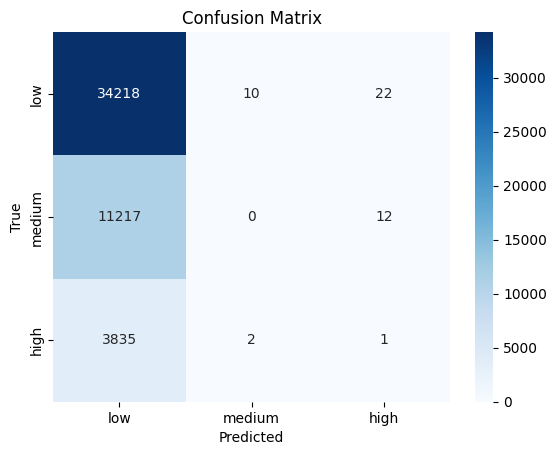

In [ ]:

print(classification_report(df_filtered['interest_level_mapped'], df_filtered['sentiment_distilBERT']))

# Calculate accuracy for three-class classification
accuracy = accuracy_score(df_filtered['interest_level_mapped'], df_filtered['sentiment_distilBERT'])

print(f"Accuracy: {accuracy * 100:.2f}%")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df_filtered['interest_level_mapped'], df_filtered['sentiment_distilBERT'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
class_counts = df_filtered['interest_level'].value_counts()
print(class_counts)

interest_level
low       34250
medium    11229
high       3838
Name: count, dtype: int64


From above we can see that the low interest class label is in majority here with almost 34,250 values,suggest us that our target variable is imbalanced which can directly affect our model.Since its a feature engineering task so thats why we have applied sentimental anakysis to the imabalance dataset.

In [ ]:
# Add distilBERT
df_final = df_filtered.copy()
df_final['final_sentiment'] = df_final['sentiment_distilBERT']
print(df_final['final_sentiment'].value_counts())

# Save to JSON
output_filename = 'sentiment_analysis_results.json'
df_final.to_json(output_filename, index=False)

print(f"\nResults saved to {output_filename}")
print("\nColumns in final JSON:")
print(df_final.columns.tolist())
print("\nSample of final predictions:")
df_final.head()

final_sentiment
0    49270
2       35
1       12
Name: count, dtype: int64

Results saved to sentiment_analysis_results.json

Columns in final JSON:
['bathrooms', 'bedrooms', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price', 'street_address', 'interest_level', 'date', 'year', 'month', 'day', 'hour', 'weekday', 'quarter', 'processed_description', 'processed_description_distilBERT', 'interest_level_mapped', 'sentiment_distilBERT', 'final_sentiment']

Sample of final predictions:


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,month,day,hour,weekday,quarter,processed_description,processed_description_distilBERT,interest_level_mapped,sentiment_distilBERT,final_sentiment
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,6,16,0,3,2,spacious bedroom bathroom in williamsburgapa...,spacious bedroom bathroom in williamsburgapa...,1,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,6,1,0,2,2,brand new gut renovated true bedroomfind your...,brand new gut renovated true bedroomfind your...,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,6,14,0,1,2,flex bedroom with full pressurized walllookin...,flex bedroom with full pressurized walllookin...,1,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,6,24,0,4,2,a brand new bedroom bath apartmentenjoy thes...,a brand new bedroom bath apartmentenjoy thes...,1,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,6,28,0,1,2,oversized studio w abundant closets available ...,oversized studio w abundant closets available ...,0,0,0
